In [1]:
import numpy as np
import numpy.random as random
import astropy
import astropy.io.fits as fits
import astropy.io.ascii as ascii
from astropy.convolution import Gaussian2DKernel
import photutils
import statmorph
from statmorph.utils.image_diagnostics import make_figure
import matplotlib
import matplotlib.pyplot as pyplot
%matplotlib inline
from PIL import Image
from astropy.convolution import *
from astropy.stats import gaussian_fwhm_to_sigma
import scipy.ndimage
import scipy as sp
import importlib as imp
import photutils
from photutils import aperture_photometry
from photutils import CircularAperture
from photutils.segmentation import SourceCatalog
from photutils.segmentation import deblend_sources
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy import units as u
import astropy.nddata
from astropy.nddata import Cutout2D
print(photutils.__version__)

1.2.0


In [2]:
im1='../outputs/TNG50-1_12_11_xyz_F200W.fits'
fo=fits.open(im1)
print(fo.info())
print(fo[0].header['BUNIT'])

Filename: ../outputs/TNG50-1_12_11_xyz_F200W.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  jwst_f200w    1 PrimaryHDU      32   (4500, 4500)   float32   
  1  InputData     1 BinTableHDU    143   8710R x 39C   [K, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   
  2  OutputData    1 BinTableHDU    101   8710R x 46C   [K, K, D, D, K, D, D, K, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   
None
nanoJanskies


In [3]:
np_flux=np.pi*(0.08/0.03)**2 ; print(1/np_flux**0.5)

0.2115710938304086


In [4]:
def add_simple_noise_extractedsn(in_hdu,radius_arcsec=0.5,extractedsn=300):


    image_in=in_hdu.data
    header_in=in_hdu.header

    #this is the approximate equation for sb magnitude input limit
    #sigma_njy=(2.0**(-0.5))*((1.0e9)*(3631.0/5.0)*10.0**(-0.4*sb_maglim))*header_in['PIXSIZE']*(3.0*header_in['FWHM'])

    #get flux in aperture
    #can we guarantee that the galaxy is in the middle?
    npix=image_in.shape[0]
    ci=np.float32(npix)/2

    radius_pixels = radius_arcsec/in_hdu.header['PIXSCALE']

    positions = [(ci, ci),]
    aperture = CircularAperture(positions, r=radius_pixels)
    phot_table = aperture_photometry(image_in, aperture)
    flux_aperture=phot_table['aperture_sum'][0]

    #get npix in aperture
    area_pixels=np.pi*radius_pixels**2



    #convert to pixel noise level
    sigma_njy=flux_aperture/(extractedsn*(area_pixels)**0.5)



    noise_image = sigma_njy*np.random.randn(npix,npix)

    image_out=image_in + noise_image

    hdu_out = fits.ImageHDU(image_out,header=header_in)
    hdu_out.header['EXTNAME']='MockImage_SN'
    hdu_out.header['EXTSN']=(extractedsn,'rough extracted S/N ratio')
    hdu_out.header['APERFLUX']=flux_aperture
    hdu_out.header['APERRAD']=radius_pixels
    hdu_out.header['RMSNOISE']=(sigma_njy,'nanojanskies')

    return hdu_out




def convolve_with_fwhm_and_rebin(in_hdu, fwhm_arcsec=0.10, desired_pix_side_arcsec=None):

    #load image data and metadata
    image_in=in_hdu.data
    header_in=in_hdu.header

    extlabel=header_in['EXTNAME'].split('_')[-1]

    pixel_size_arcsec=header_in['pixscale']

    sigma_arcsec=fwhm_arcsec*gaussian_fwhm_to_sigma
    sigma_pixels=sigma_arcsec/pixel_size_arcsec

    image_out=sp.ndimage.filters.gaussian_filter(image_in,sigma_pixels,mode='nearest')


    if desired_pix_side_arcsec is not None:
        np_orig=image_out.shape[0]

        np_new=np_orig*pixel_size_arcsec/desired_pix_side_arcsec
        np_new_int=np.int64(np_new)

        orig_fov = np_orig*pixel_size_arcsec
        new_fov = np_new_int*desired_pix_side_arcsec
        diff = (orig_fov-new_fov)/2.0

        box_arcsec=(diff,diff,orig_fov-diff,orig_fov-diff)
        box=(diff/pixel_size_arcsec,diff/pixel_size_arcsec,(orig_fov-diff)/pixel_size_arcsec,(orig_fov-diff)/pixel_size_arcsec)

        #multiply by pixel scale ratio squared in order to preserve total flux
        rebinned_image=np.asarray(Image.fromarray(image_out).resize(size=(np_new_int, np_new_int),box=box))*(desired_pix_side_arcsec/pixel_size_arcsec)**2

        final_image=rebinned_image
        out_pix_arcsec = desired_pix_side_arcsec
    else:
        final_image=image_out
        out_pix_arcsec = pixel_size_arcsec

    hdu_out = fits.ImageHDU(final_image,header=header_in)
    hdu_out.header['FWHM']=(fwhm_arcsec,'arcsec')
    hdu_out.header['SIGMA']=(sigma_arcsec,'arcsec')
    hdu_out.header['EXTNAME']='MockData_PSF_'+extlabel
    hdu_out.header['PIXSCALE']=(out_pix_arcsec,'arcsec')
    hdu_out.header['PIXORIG']=(pixel_size_arcsec,'arcsec, pristine image')
    hdu_out.header['IN_EXT']=header_in['EXTNAME']

    return hdu_out


In [109]:
#make some intermediate things
ph_435=fits.open('../outputs/TNG50-1_12_11_xyz_F435W.fits')[0]
ph_814=fits.open('../outputs/TNG50-1_12_11_xyz_F814W.fits')[0]
ph_200=fits.open('../outputs/TNG50-1_12_11_xyz_F200W.fits')[0]
ph_277=fits.open('../outputs/TNG50-1_12_11_xyz_F200W.fits')[0]
ph_356=fits.open('../outputs/TNG50-1_12_11_xyz_F435W.fits')[0]

cat_435=fits.open('../outputs/TNG50-1_12_11_xyz_F435W.fits')[2]
cat_814=fits.open('../outputs/TNG50-1_12_11_xyz_F814W.fits')[2]
cat_200=fits.open('../outputs/TNG50-1_12_11_xyz_F200W.fits')[2]
cat_277=fits.open('../outputs/TNG50-1_12_11_xyz_F200W.fits')[2]
cat_356=fits.open('../outputs/TNG50-1_12_11_xyz_F356W.fits')[2]

In [110]:
psfh_435=convolve_with_fwhm_and_rebin(ph_435,fwhm_arcsec=0.04)
psfh_814=convolve_with_fwhm_and_rebin(ph_814,fwhm_arcsec=0.08)
psfh_200=convolve_with_fwhm_and_rebin(ph_200,fwhm_arcsec=0.08)
psfh_356_03=convolve_with_fwhm_and_rebin(ph_356,fwhm_arcsec=0.12)
psfh_277_03=convolve_with_fwhm_and_rebin(ph_277,fwhm_arcsec=0.09)
psfh_356_06=convolve_with_fwhm_and_rebin(ph_356,fwhm_arcsec=0.12,desired_pix_side_arcsec=0.06)

In [7]:
s1 = 0.02 ; s2 = 0.20 ; s3 = 2.0 #noise levels in njy

In [8]:
wcs_200 = wcs.WCS(psfh_200)
print(wcs_200)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 0.0  0.0  
CRPIX : 2250.0  2250.0  
PC1_1 PC1_2  : 8.3333333333333e-06  0.0  
PC2_1 PC2_2  : 0.0  8.3333333333333e-06  
CDELT : 1.0  1.0  
NAXIS : 4500  4500


In [57]:
def do_photutils_stuff(image,nlevels=32,contrast=0.001,npixels=10):
        

    threshold = photutils.detect_threshold(image, 1.5)
    kernel_sigma = 3.0 / (2.0 * np.sqrt(2.0 * np.log(2.0)))  # FWHM = 3
    kernel = Gaussian2DKernel(kernel_sigma, x_size=9, y_size=9)
    kernel.normalize()
    segm = photutils.detect_sources(image, threshold, npixels, filter_kernel=kernel)
    
    cat = SourceCatalog(image, segm)
    tbl = cat.to_table()
    
    #need a deblending step here!
    segm_deblend = deblend_sources(image, segm, kernel=kernel, npixels=npixels,nlevels=nlevels, contrast=contrast)
    
    db_cat = SourceCatalog(image,segm_deblend)
    db_tbl=db_cat.to_table()
    
    return segm_deblend,db_tbl,db_cat

In [135]:
def source_match(test_source,mockcatalog,image,segm,image_wcs,zoom=3,show=True):

    source_sc = image_wcs.pixel_to_world(test_source.xcentroid,test_source.ycentroid)
    dx=test_source.bbox.ixmax - test_source.bbox.ixmin 
    dy=test_source.bbox.iymax - test_source.bbox.iymin 
    
    cut=Cutout2D(image,source_sc,(dy*zoom,dx*zoom),wcs=image_wcs,mode='strict')

    
    catpix_x,catpix_y=cut.wcs.world_to_pixel(SkyCoord(mockcatalog.data['RA degree']*u.deg,u.deg*mockcatalog.data['DEC degree']))
    
    catpix_x_im,catpix_y_im=image_wcs.world_to_pixel(SkyCoord(mockcatalog.data['RA degree']*u.deg,u.deg*mockcatalog.data['DEC degree']))

    
    psep = ((catpix_x_im-test_source.xcentroid)**2 + (catpix_y_im-test_source.ycentroid)**2)**0.5
    
    fratio= np.abs(test_source.segment_flux - mockcatalog.data['total_quant'])/test_source.segment_flux
    
    candidates = np.logical_and(psep < 25, fratio < 0.5)
    
    #if 1, assume decent match and proceed.
    if np.sum(candidates)==1:
        catalog_match=mockcatalog.data[candidates]
        colnames=mockcatalog.data.names
        catdict={}
        
        for name,datapoint in zip(colnames,catalog_match[0]):
            catdict[name]=datapoint
            
            
        catdict['x_pix']=catpix_x_im[candidates][0]
        catdict['y_pix']=catpix_y_im[candidates][0]
        return catdict
    else:
        return None
    
    #cpx=catpix_x - cut.
    #cpy=catpix_y - cut.
    
    if show is True:
        f=pyplot.figure(figsize=(8,4),dpi=600)
        pyplot.subplots_adjust(wspace=0.0,hspace=0.0,top=1.0,right=1.0,left=0.00,bottom=0.00)
    
        ax=f.add_subplot(141)
        ax.set_xticks([]) ; ax.set_yticks([])
    
        ax.imshow(test_source.data,interpolation='nearest',aspect='auto',origin='lower')

        ax=f.add_subplot(142)
        ax.set_xticks([]) ; ax.set_yticks([])

        ax.imshow(test_source.segment,interpolation='nearest',aspect='auto',origin='lower')
        
        ax=f.add_subplot(143)
        ax.set_xticks([]) ; ax.set_yticks([])


        ax.imshow(cut.data,interpolation='nearest',aspect='auto')

        ax.plot(catpix_x[candidates],catpix_y[candidates],'+',color='red',markersize=10)
        
        ax.set_xlim(0,dx*zoom) ; ax.set_ylim(0,dy*zoom)
        
        ax.set_xticks([]) ; ax.set_yticks([])

        
        
        ax=f.add_subplot(144)
        ax.set_xticks([]) ; ax.set_yticks([])

        
        
    return candidates


In [116]:
npix=psfh_200.data.shape[0]

im_200_1=psfh_200.data+s1*np.random.randn(npix,npix)
im_200_2=psfh_200.data+s2*np.random.randn(npix,npix)
im_200_3=psfh_200.data+s3*np.random.randn(npix,npix)

im_435_1=psfh_435.data+s1*np.random.randn(npix,npix)
im_814_1=psfh_814.data+s1*np.random.randn(npix,npix)
im_277_1=psfh_277_03.data+s1*np.random.randn(npix,npix)
im_356_1=psfh_356_03.data+s1*np.random.randn(npix,npix)



In [58]:
segm_1,tbl_1,scat_1 = do_photutils_stuff(im_200_1)

In [65]:
totals=tbl_1['segment_flux']
labels = tbl_1['label']
mags = -2.5*np.log10(1.0e-9*totals/3631.0)
si=np.logical_and(mags < 29, mags > 24.0)
print(np.max(totals), np.sum(si), cat_200.data.shape)

172008.55930515614 2827 (8710,)


In [67]:
segm_1.keep_labels(labels[si])

/var/folders/rf/h5shlcys5lvck76n5wn4wwrm00019s/T/ipykernel_46318/1021820613.py:5: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(im_200_1[0:n,0:n]))


(0.0, 1000.0)

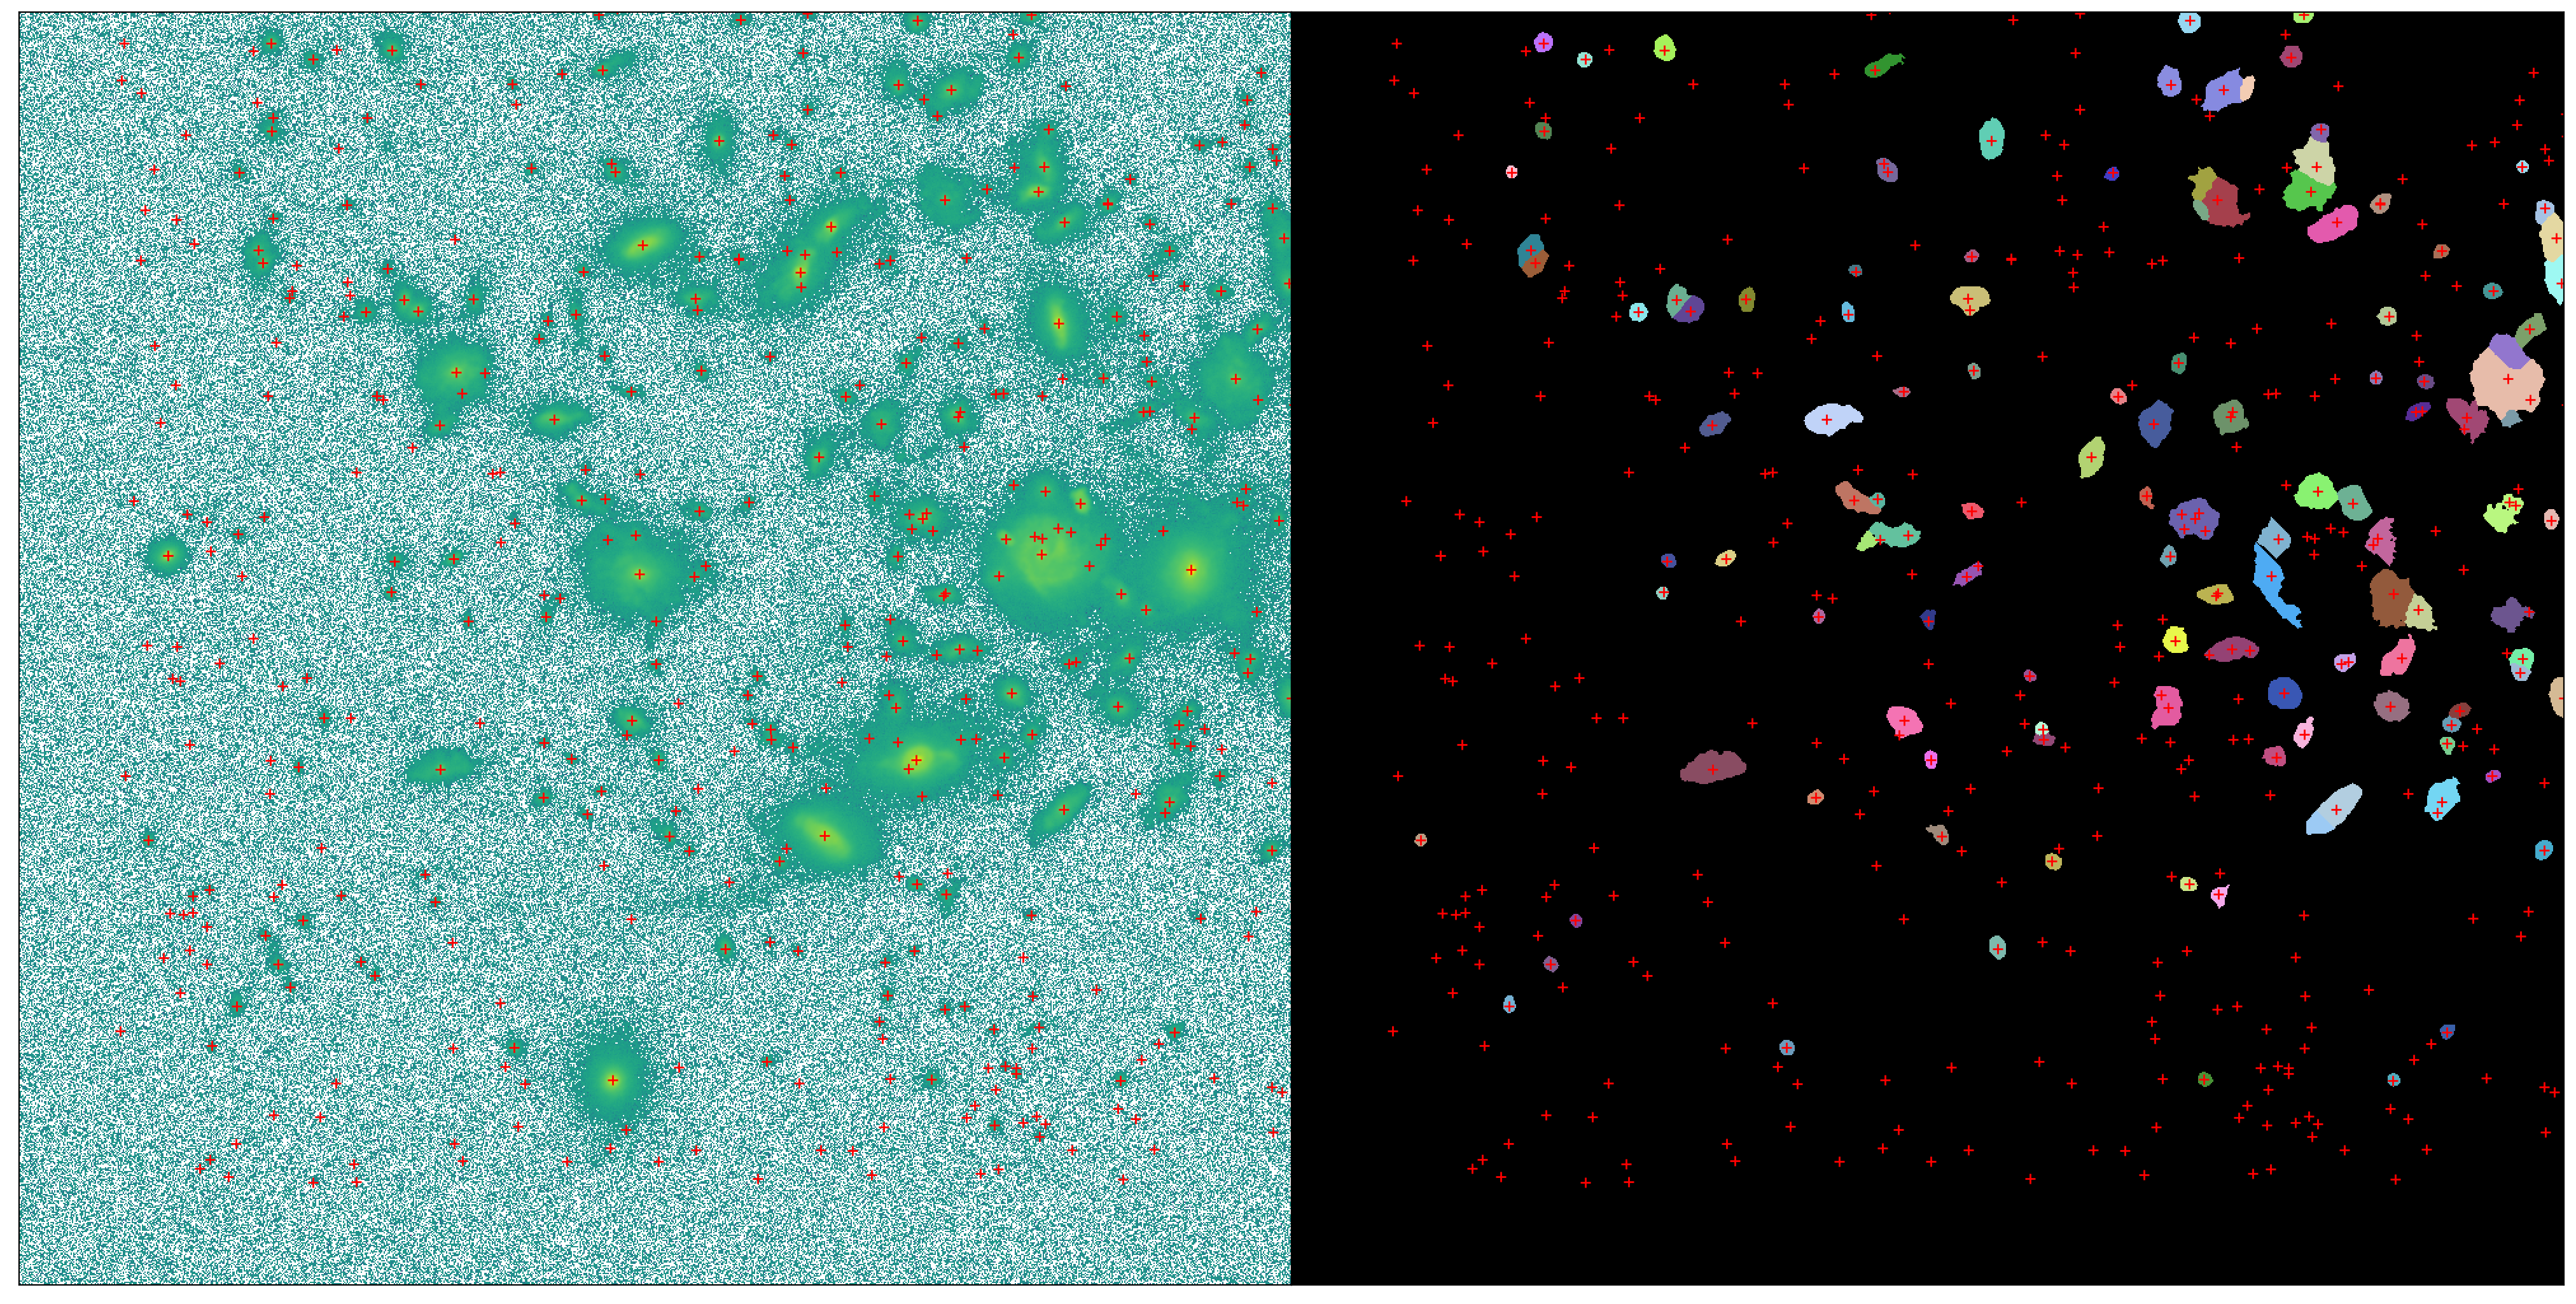

In [68]:
n=1000
f=pyplot.figure(figsize=(20,10),dpi=200)
pyplot.subplots_adjust(wspace=0.0,hspace=0.0,top=1.0,right=1.0,left=0.00,bottom=0.00)
ax=f.add_subplot(121)
ax.imshow(np.log10(im_200_1[0:n,0:n])) 
ax.set_xticks([]) ; ax.set_yticks([])

catpix_x,catpix_y=wcs_200.world_to_pixel(SkyCoord(cat_200.data['RA degree']*u.deg,u.deg*cat_200.data['DEC degree']))
ax.plot(catpix_x,catpix_y,'+',color='red')
ax.set_xlim(0,n) ; ax.set_ylim(0,n)

ax=f.add_subplot(122)
ax.set_xticks([]) ; ax.set_yticks([])
cmap = segm_1.make_cmap(seed=123)
pyplot.imshow(segm_1.data[0:n,0:n],cmap=cmap)
ax.plot(catpix_x,catpix_y,'+',color='red')
ax.set_xlim(0,n) ; ax.set_ylim(0,n)

In [112]:

outputs_dir='morphology_diagnostics_1'
f200_dir=os.path.join(outputs_dir,'f200w')
f435_dir=os.path.join(outputs_dir,'f435w')
f814_dir=os.path.join(outputs_dir,'f814w')
f277_dir=os.path.join(outputs_dir,'f277w')
f356_dir=os.path.join(outputs_dir,'f356w')

if not os.path.lexists(outputs_dir):
    os.makedirs(outputs_dir)
if not os.path.lexists(f200_dir):
    os.makedirs(f200_dir)
if not os.path.lexists(f435_dir):
    os.makedirs(f435_dir)
if not os.path.lexists(f814_dir):
    os.makedirs(f814_dir)
if not os.path.lexists(f277_dir):
    os.makedirs(f277_dir)
if not os.path.lexists(f356_dir):
    os.makedirs(f356_dir)

In [146]:

def get_catline_header():
    header=''
    return header

def get_catline(so,cdict,sm):
    
    stuff_tuple=(cdict['Snapshot number'],
                cdict['Subhalo index'],
                cdict['True z'],
                cdict['total_quant'],
                cdict['Stellar mass w2sr'],
                cdict['Total gas mass w2sr'],
                cdict['Total subhalo mass'],
                cdict['Total BH mass w2sr'],
                cdict['Total baryon mass w2sr'],
                cdict['SFR w2sr'],
                cdict['Total BH accretion rate'],
                cdict['x_pix'],
                cdict['y_pix'],
                so.label,
                so.xcentroid,
                so.ycentroid,
                sm.flag,
                sm.flag_sersic,
                sm.flag_catastrophic,
                sm.gini,
                sm.m20,
                sm.gini_m20_bulge,
                sm.gini_m20_merger,
                sm.sn_per_pixel,
                sm.concentration,
                sm.asymmetry,
                sm.rhalf_ellip,
                sm.rpetro_ellip,
                sm.flux_ellip,
                sm.xc_centroid,
                sm.yc_centroid,
                sm.sersic_n,
                sm.sersic_rhalf,
                sm.shape_asymmetry,
                sm.multimode,
                sm.intensity,
                sm.deviation,
                sm.label)

    line='{:10d} {:10d} {:15.8f} '\
        '{:12.8f} {:12.8} {:12.8} {:12.8} {:12.8} {:12.8} {:12.8f} {:12.8f} '\
        '{:10.6f} {:10.6f} '\
        '{:10d} {:10.6f} {:10.6f} '\
        '{:10d} {:10d} {:10d} {:10.6f} {:10.6f} {:10.6f} {:10.6f} {:10.6f} '\
        '{:10.6f} {:10.6f} {:10.6f} {:10.6f} {:10.6f} {:10.6f} {:10.6f} '\
        '{:10.6f} {:10.6f} {:10.6f} {:10.6f} {:10.6f} {:10.6f} {:10d}\n'.format(*stuff_tuple)
    
    return line

In [152]:
def make_sm_fig(source_morph,thisdir,filelabel):
    fig = make_figure(source_morph)
    fig.savefig(os.path.join(thisdir,'statmorph_'+filelabel+'.png'),dpi=150)
    pyplot.close(fig)
    return

In [153]:
pyplot.ioff()

morphcat_200 = open(os.path.join(f200_dir,'morphcat_1.txt'),'w')
morphcat_435 = open(os.path.join(f435_dir,'morphcat_1.txt'),'w')
morphcat_814 = open(os.path.join(f814_dir,'morphcat_1.txt'),'w')
morphcat_277 = open(os.path.join(f277_dir,'morphcat_1.txt'),'w')
morphcat_356 = open(os.path.join(f356_dir,'morphcat_1.txt'),'w')

for test_source in scat_1[si][0:200]:
    cdict=source_match(test_source,cat_200,im_200_1,segm_1,wcs_200,show=False)
    if cdict!=None:
        print('match found!')
        
        seg_copy=segm_1.copy()
        seg_copy.keep_label(test_source.label)
        
        source_morph_200 = statmorph.source_morphology(im_200_1, seg_copy.data, gain=5)
        source_morph_435 = statmorph.source_morphology(im_435_1, seg_copy.data, gain=5)
        source_morph_814 = statmorph.source_morphology(im_814_1, seg_copy.data, gain=5)
        source_morph_356 = statmorph.source_morphology(im_356_1, seg_copy.data, gain=5)
        source_morph_277 = statmorph.source_morphology(im_277_1, seg_copy.data, gain=5)
        
        
        filelabel=str(cdict['Snapshot number'])+'_'+str(cdict['Subhalo index'])+'_'+str(test_source.label)
        
        try:
            make_sm_fig(source_morph_200[0],f200_dir,filelabel)
        except AssertionError as AE:
            pass
        try:
            make_sm_fig(source_morph_435[0],f435_dir,filelabel)
        except AssertionError as AE:
            pass
        try:
            make_sm_fig(source_morph_814[0],f814_dir,filelabel)
        except AssertionError as AE:
            pass
        try:
            make_sm_fig(source_morph_277[0],f277_dir,filelabel)
        except AssertionError as AE:
            pass
        try:
            make_sm_fig(source_morph_356[0],f356_dir,filelabel)
        except AssertionError as AE:
            pass
        
        
        catline_200=get_catline(test_source,cdict,source_morph_200[0])
        morphcat_200.write(catline_200)
        catline_435=get_catline(test_source,cdict,source_morph_435[0])
        morphcat_435.write(catline_435)
        catline_814=get_catline(test_source,cdict,source_morph_814[0])
        morphcat_814.write(catline_814)
        catline_277=get_catline(test_source,cdict,source_morph_277[0])
        morphcat_277.write(catline_277)
        catline_356=get_catline(test_source,cdict,source_morph_356[0])
        morphcat_356.write(catline_356)
        

morphcat_200.close()
morphcat_435.close()
morphcat_814.close()
morphcat_277.close()
morphcat_356.close()

match found!
match found!
match found!


match found!
match found!
match found!


match found!


match found!
match found!


match found!


match found!


match found!


match found!


match found!
match found!


match found!


match found!


match found!


match found!


match found!


match found!
match found!


match found!


match found!
match found!
match found!
match found!
match found!


match found!


match found!


match found!


match found!


match found!
match found!


match found!


match found!


match found!


match found!


match found!


match found!
match found!


match found!


match found!


match found!


match found!


match found!


match found!


match found!
match found!


match found!


match found!


match found!


match found!


match found!


match found!


match found!


match found!


match found!
match found!


match found!


match found!
match found!


match found!


match found!


match found!


match found!


match found!


match found!


match found!


/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)
/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)


match found!
match found!


match found!
match found!


match found!
match found!


match found!


match found!


match found!
match found!


match found!


match found!
match found!


match found!


match found!


match found!
match found!


match found!


match found!


match found!


match found!


match found!


match found!


match found!


match found!


match found!


match found!


/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)
/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)
/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)


match found!


match found!


match found!
match found!


match found!


match found!
match found!


match found!


match found!


match found!


match found!


match found!


match found!


match found!


match found!


match found!
match found!


match found!
match found!
match found!
match found!


match found!


match found!


/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)
/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)


match found!


match found!


match found!
match found!


match found!


/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)
/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)
/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)


match found!


match found!
match found!
match found!


match found!


match found!


match found!


match found!


match found!


/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)
/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)


match found!


match found!
match found!


/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)


match found!


match found!
match found!


match found!


match found!


match found!


match found!
match found!


match found!
match found!


match found!
match found!


match found!
match found!
match found!


/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)
/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)
/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)


match found!


/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)
/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)


match found!
match found!


match found!


match found!
match found!


match found!


match found!


match found!


match found!


match found!
match found!


match found!


match found!


match found!


match found!


match found!


match found!


/Users/gsnyder/miniconda3/envs/mocks-paper/lib/python3.9/site-packages/statmorph/utils/image_diagnostics.py:242: UserWarning: No contour levels were found within the data range.
  ax.contour(Z, contour_levels, colors=contour_colors, linewidths=1.5)


match found!
match found!


In [ ]:
pyplot.loglog(cat_200.data['total_quant'][idx],tbl_1['segment_flux'][si],'ok') ; pyplot.xlim(100,10000) ; pyplot.ylim(100,10000)

In [ ]:
print(d2d[10], d2d[10].value, d2d[10].value*3600, s3d.data.lon.value[10])
c=d2d[0]


In [ ]:
pyplot.hist(np.log10(d2d.arcsec),bins=50)

In [21]:
%%time
source_morphs = statmorph.source_morphology(im_200_1, segm_1.data, gain=5)

CPU times: user 29.1 s, sys: 169 ms, total: 29.2 s
Wall time: 29.2 s


In [22]:
source_morphs

In [23]:
m1=source_morphs[0]

In [119]:
for k in m1.__dict__.keys():
    print(k)

_image
_segmap
label
_mask
_weightmap
_gain
_psf
_cutout_extent
_min_cutout_size
_n_sigma_outlier
_annulus_width
_eta
_petro_fraction_gini
_skybox_size
_petro_extent_cas
_petro_fraction_cas
_boxcar_size_mid
_niter_bh_mid
_sigma_mid
_petro_extent_flux
_boxcar_size_shape_asym
_sersic_maxiter
_segmap_overlap_ratio
_verbose
flag
flag_sersic
flag_catastrophic
_use_centroid
_slice_stamp
_mask_stamp_nan
num_badpixels
ymax_stamp
ymin_stamp
ny_stamp
xmax_stamp
xmin_stamp
nx_stamp
_mask_stamp_badpixels
_mask_stamp
_mask_stamp_no_bg
_cutout_stamp_maskzeroed_no_bg
_centroid
xc_centroid
_xc_stamp
yc_centroid
_yc_stamp
_cutout_stamp_maskzeroed
_x_maxval_stamp
_y_maxval_stamp
_covariance_centroid
_eigvals_centroid
ellipticity_centroid
elongation_centroid
orientation_centroid
_diagonal_distance
_rpetro_circ_centroid
_slice_skybox
_sky_asymmetry
_asymmetry_center
xc_asymmetry
yc_asymmetry
_covariance_asymmetry
_eigvals_asymmetry
ellipticity_asymmetry
elongation_asymmetry
orientation_asymmetry
rpetro_ci

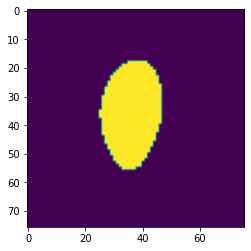

In [28]:
pyplot.imshow(m1._segmap_gini)

In [71]:
cat_200 = fo[2]

In [72]:
cat_200.data.columns

ColDefs(
    name = 'image_success'; format = 'K'
    name = 'primary_flag'; format = 'K'
    name = 'photrad_kpc'; format = 'D'
    name = 'cutoutfov_kpc'; format = 'D'
    name = 'cutout_size'; format = 'K'
    name = 'n_arcmin'; format = 'D'
    name = 'total_quant'; format = 'D'
    name = 'Snapshot number'; format = 'K'
    name = 'Subhalo index'; format = 'K'
    name = 'RA degree'; format = 'D'
    name = 'DEC degree'; format = 'D'
    name = 'RA true z'; format = 'D'
    name = 'DEC true z'; format = 'D'
    name = 'RA inferred z'; format = 'D'
    name = 'DEC inferred z'; format = 'D'
    name = 'True z'; format = 'D'
    name = 'Inferred z'; format = 'D'
    name = 'Peculiar z'; format = 'D'
    name = 'True scale'; format = 'D'
    name = 'Comoving X'; format = 'D'
    name = 'Comoving Y'; format = 'D'
    name = 'Comoving Z'; format = 'D'
    name = 'True angular distance'; format = 'D'
    name = 'Inferred angular distance'; format = 'D'
    name = 'Snapshot z'; format = '

In [102]:
cat_row=cat_200.data[55]
colnames=cat_200.data.names


In [103]:
cd={}
for n,r in zip(colnames,cat_row):
    cd[n]=r

In [104]:
cd

{'image_success': 1,
 'primary_flag': 1,
 'photrad_kpc': 0.38795394154118684,
 'cutoutfov_kpc': 50.69751992914083,
 'cutout_size': 321,
 'n_arcmin': 0.16049999999999998,
 'total_quant': 3.94262433052063,
 'Snapshot number': 75,
 'Subhalo index': 866993,
 'RA degree': 0.006455,
 'DEC degree': 0.010739,
 'RA true z': 118.82,
 'DEC true z': 197.69,
 'RA inferred z': 118.87,
 'DEC inferred z': 197.78,
 'True z': 0.36834815,
 'Inferred z': 0.36860892,
 'Peculiar z': 0.00026077,
 'True scale': 5.1134,
 'Comoving X': 0.1626,
 'Comoving Y': 0.2705,
 'Comoving Z': 1443.2043,
 'True angular distance': 1054.7056,
 'Inferred angular distance': 1055.1842,
 'Snapshot z': 0.3479,
 'Geometric z': 0.3538,
 'Lightcone number': 27,
 'Stellar mass w2sr': 1309900.0,
 'Total gas mass w2sr': 9110200.0,
 'Total subhalo mass': 7567800000.0,
 'Total BH mass w2sr': 0.0,
 'Total baryon mass w2sr': 10420000.0,
 'SFR w2sr': 0.0,
 'Total BH accretion rate': 0.0,
 'Camera X': 0.1188,
 'Camera Y': 0.1977,
 'Camera Z':

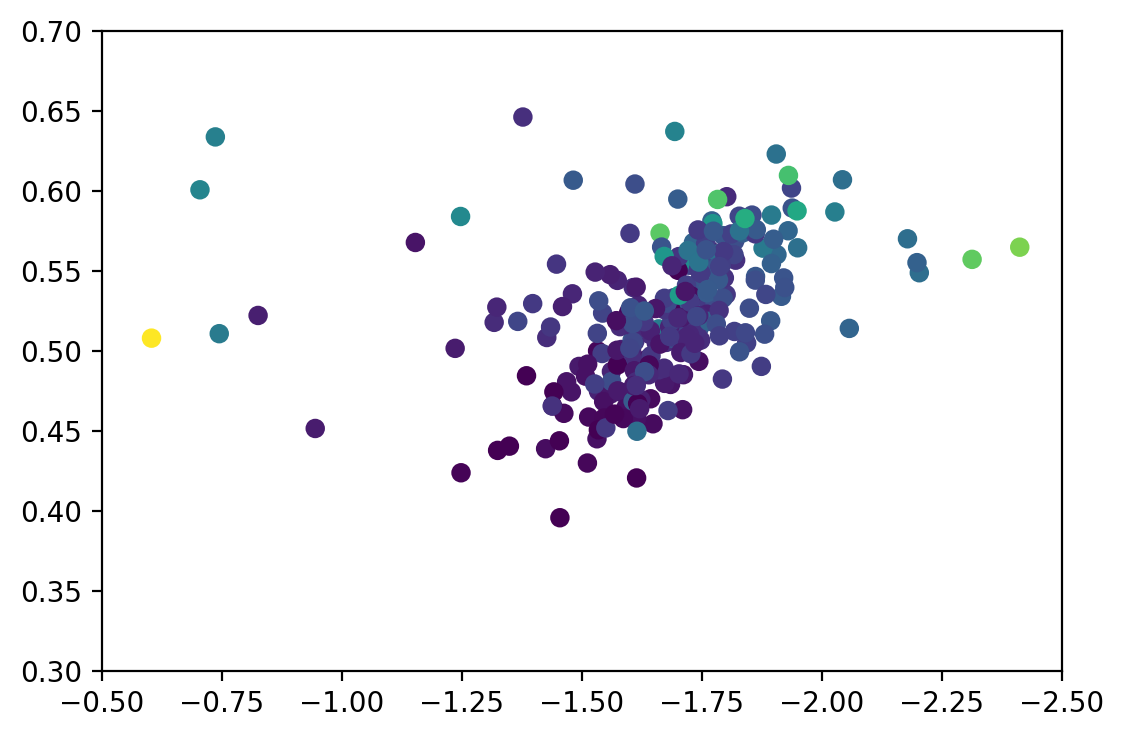

In [12]:
import run_mocks_morphs as rmm
imp.reload(rmm)

head,names,no=rmm.get_catline_header()

morph_200=ascii.read('morphology_diagnostics_tng50_1/f200w/morphcat_tng50_1.txt',names=names)
morph_814=ascii.read('morphology_diagnostics_tng50_1/f814w/morphcat_tng50_1.txt',names=names)
morph_435=ascii.read('morphology_diagnostics_tng50_1/f435w/morphcat_tng50_1.txt',names=names)
morph_356=ascii.read('morphology_diagnostics_tng50_1/f356w/morphcat_tng50_1.txt',names=names)
morph_277=ascii.read('morphology_diagnostics_tng50_1/f277w/morphcat_tng50_1.txt',names=names)


f=pyplot.figure(figsize=(6,4),dpi=200)
pyplot.subplots_adjust(wspace=0.0,hspace=0.0,top=1.0,right=1.0,left=0.20,bottom=0.20)
ax=f.add_subplot(111)

gi=morph_200['sm_flag']==0

ax.scatter((morph_200['sm_m20'][gi]),morph_200['sm_gini'][gi],c=morph_200['sm_sersic_n'][gi],vmax=3,vmin=0.5)
ax.set_xlim(-0.5,-2.5) ; ax.set_ylim(0.3,0.7)


f.savefig('g_m20_tng50_1.png',dpi=200)